In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.preprocessing import StandardScaler
import scipy.io
from sklearn.metrics.cluster import normalized_mutual_info_score

import os
os.chdir('/content/drive/MyDrive/한양대/2021-1 빅데이터기반기계학습및응용/ref/project/Mike')


swissroll_3d = np.loadtxt("swissroll.dat")
swissroll_2d = np.loadtxt("preswissroll.dat")
swissroll_label = np.loadtxt("preswissroll_labels.dat")

mat = scipy.io.loadmat('yalefaces/Yale_32x32.mat') #dictionary variable
print(mat.keys())
yalefaces = mat["X"]
yalefaces_label = mat["Y"]

data_original = swissroll_3d
label = swissroll_label

#data_original = yalefaces
#label = yalefaces_label

scaler = StandardScaler()
data = scaler.fit_transform(data_original)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y'])


In [3]:
n_clusters = int(max(label)-min(label)+1)

feature_range = np.arange(50, 151, 25)
neighbor_range = np.arange(10, 151, 20)


In [ ]:
#LLE


NMI_list = []
n_nbrs_list = []
for i_nbrs in range(3, 154, 10):

    n_nbrs_list = np.append(n_nbrs_list, i_nbrs)
    n_features = 100

    lle = LocallyLinearEmbedding(n_components=50, n_neighbors=i_nbrs)
    data_on_lle = lle.fit_transform(data)

    kmc_lle = KMeans(n_clusters=n_clusters, n_init=100, max_iter=300, tol=0.0001)
    lle_clusters = kmc_lle.fit_predict(data_on_lle)
    NMI_list = np.append(NMI_list, normalized_mutual_info_score(label.reshape(-1),lle_clusters.reshape(-1)))

plt.plot(n_nbrs_list,NMI_list )
plt.ylim(0,0.4)
print(NMI_list)

lle_NMIs = NMI_list

In [30]:
lle.get_params()

{'eigen_solver': 'auto',
 'hessian_tol': 0.0001,
 'max_iter': 100,
 'method': 'standard',
 'modified_tol': 1e-12,
 'n_components': 100,
 'n_jobs': None,
 'n_neighbors': 11,
 'neighbors_algorithm': 'auto',
 'random_state': 23,
 'reg': 0.001,
 'tol': 1e-06}

In [ ]:
#Spectral Embedding
#data = StandardScaler().fit_transform(noisy_circles)
#data = StandardScaler().fit_transform(noisy_moons)
#data = StandardScaler().fit_transform(swissroll_3d)

data = yalefaces

label = yalefaces_label
n_clusters = int(max(label)-min(label)+1)

NMI_list = []
n_nbrs_list = []
for i_nbrs in range(3, 13, 2):

    n_nbrs_list = np.append(n_nbrs_list, i_nbrs)
    n_features = 100

    se = SpectralEmbedding(n_components=100, affinity='nearest_neighbors', n_neighbors=i_nbrs)
    data_on_se = se.fit_transform(data)

    kmc_se = KMeans(n_clusters=n_clusters, n_init=100, max_iter=300, tol=0.0001)
    se_clusters = kmc_se.fit_predict(data_on_se)

    NMI_list = np.append(NMI_list, normalized_mutual_info_score(label.reshape(-1),se_clusters.reshape(-1)))


plt.plot(n_nbrs_list,NMI_list )
plt.ylim(0,0.4)
print(NMI_list)

se_NMIs = NMI_list

In [5]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pywt
from scipy.sparse import csr_matrix
from sklearn.neighbors import kneighbors_graph
from numpy import savetxt


def find_neighbors(X, n_neighbors=6):
    """
    Compute the square distance matrix using Euclidean distance
    :param X: Input data, a numpy array of shape (n, d)
    :param n_neighbors: Number of nearest neighbors to consider, int
    :return: numpy array of shape (n, n_neighbors), numpy array of shape (n, n_neighbors)
    """
    def dist(a, b):
        return np.sqrt(sum((a - b)**2))

    # Compute full distance matrix (n , n)
    #print("cal. distance")
    distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])
    #print("cal. distance finished")

    # by default, Keep only the 6 nearest neighbors, others set to 0 (= unreachable)
    neighbor_idx = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]

    return neighbor_idx

def find_nbrs(X, n_neighbors=6):
    n = X.shape[0]
    neighbors_idx = np.zeros((n,n_neighbors))

    A = kneighbors_graph(X, n_neighbors, mode='connectivity', p=2, include_self=False)
    #A = csr_matrix(A)
    for i in range(0,n):
        neighbors_idx[i] = A[i].indices

    return neighbors_idx.astype(int)

def weight_LLE(data, n_neighbors=6):
    n = data.shape[0]
    # Compute the nearest neighbors
    neighbors_idx = np.zeros((n,n_neighbors))

    print("finding neighbors")
    neighbors_idx = find_neighbors(data, n_neighbors)


    #A = kneighbors_graph(data, n_neighbors, mode='connectivity', include_self=False)
    #A = csr_matrix(A)
    '''
    for i in range(0,n):
        neighbors_idx[i] = A[i].indices
    '''
    w = np.zeros((n, n))

    print("calculating weights")
    for i in range(n):
        # Center the neighbors matrix
        k_indexes = neighbors_idx[i, :]
        neighbors = data[k_indexes, :] - data[i, :]

        # Compute the corresponding gram matrix
        gram_inv = np.linalg.pinv(np.dot(neighbors, neighbors.T))

        # Setting the weight values according to the lagrangian
        lambda_par = 2/np.sum(gram_inv)
        w[i, k_indexes] = lambda_par*np.sum(gram_inv, axis=1)/2

        #if i%(np.int(n/10)) == 0:
        #    print(i/np.int(n/10)*10,"%")

    return w



In [6]:
def robust_neighbor_embedding(X, n_neighbors, out_dim, tol=1e-6, max_iter=200, mode=1):
    
    if mode == 2:
        #spectral embedding's weight matrix
        
        #se = SpectralEmbedding(n_components=out_dim, affinity='nearest_neighbors', n_neighbors=n_neighbors)
        #se.fit(data)
        #W = se.affinity_matrix_.A
        W = kneighbors_graph(X, n_neighbors, mode='connectivity', p=2, include_self=False)
        W = W.A/n_neighbors
        print(W.shape)
    else: #by default
        # LLE's weight matrix
        W = weight_LLE(X, n_neighbors)

    n,d = X.shape
    H = np.random.rand(d,out_dim)
    ## W
    
    # M = (I-W)' (I-W)
    #A = eye(*W.shape, format=W.format) - W
    #A = (A.T).dot(A).tocsr()
    A = np.dot((np.eye(n) - np.transpose(W)), X)    
    AA = np.dot(A.T,A) #.tocsr()
    AAplus = 0.5 * (np.abs(AA) + AA)
    AAsubtract = 0.5 * (np.abs(AA) - AA)
    
    #initialize H, Y, alpha, gamma, gamma_max, mu
    M = np.dot(A, H)
    Y = np.zeros((n,out_dim))
    mu = 1.1
    gamma = 10
    max_gamma = 10000000000.0
    alpha = 1000.0
    iter_num = 50
    iter_numH = 30

    eps = 0.0001
    print(iter_num," iterations")
    for j in np.arange(1, iter_num+1):
        AM = np.dot(np.transpose(A), M)
        AY = np.dot(np.transpose(A), Y)
        AMplus = 0.5 * (np.abs(AM) + AM)
        AMsubtract = 0.5 * (np.abs(AM) - AM)
        AYplus = 0.5 * (np.abs(AY) + AY)
        AYsubtract = 0.5 * (np.abs(AY) - AY)

        #update H
        for i in np.arange(1, iter_numH+1):

            G1 = np.diag(np.sqrt(1.0 / np.diag(np.dot(np.transpose(H), H)) + eps))
            #print("G1", G1)
            H = np.dot(H, G1)
            a = (np.dot((alpha * H ), np.dot(np.transpose(H), H))+gamma * AMsubtract + gamma * np.dot(AAplus,H)+ AYsubtract + eps)
            c = ((alpha * H) + (gamma * AMplus) + np.dot(gamma*AAsubtract, H) + AYplus)
            H = H * np.sqrt(c/a)        
        
        # Update M
        temp = np.dot(A,H)-Y/gamma
        M = pywt.threshold(temp,1/gamma, mode='soft')

        # Update Y
        Y = Y + gamma*(M-np.dot(A,H))
        
        # Update gamma
        gamma = min(mu*gamma,max_gamma)
        print(end=".")

    print(end='\n')
    index_amplitude = np.sum(H*H,axis=1) #contribution of each feature 1~d
    ranking = np.argsort(-index_amplitude) #biggest first
    selected_index = ranking[0:out_dim] #select 1~out_dim

    X_rne = X[:,selected_index]


    return X_rne, selected_index, H

In [ ]:
# apply RNE to data 
data = yalefaces
label = yalefaces_label
n_clusters = int(max(label)-min(label)+1)


RNE_NMIs = np.zeros((feature_range.shape[0], neighbor_range.shape[0]))
f_i=0
for n_features in feature_range:
    n_i=0
    for n_neighbors in neighbor_range:
        print(n_features,"feature, ",n_neighbors, "neighbors")
        data_on_rne, indexes, H = robust_neighbor_embedding(data, n_neighbors=n_neighbors, out_dim=n_features,mode=2)
        kmc = KMeans(n_clusters=n_clusters, n_init=100, max_iter=300, tol=0.0001)
        rne_clusters = kmc.fit_predict(data_on_rne)
        RNE_NMIs[f_i, n_i] = normalized_mutual_info_score(label.reshape(-1),rne_clusters.reshape(-1))
        n_i += 1
    f_i += 1

# save to csv file
savetxt('RNE_mod2.csv', RNE_NMIs.T, delimiter=' ')


50 feature,  10 neighbors
(165, 165)
50  iterations
..................................................
50 feature,  30 neighbors
(165, 165)
50  iterations
..................................................
50 feature,  50 neighbors
(165, 165)
50  iterations
..................................................
50 feature,  70 neighbors
(165, 165)
50  iterations
..................................................
50 feature,  90 neighbors
(165, 165)
50  iterations
..................................................
50 feature,  110 neighbors
(165, 165)
50  iterations
..................................................
50 feature,  130 neighbors
(165, 165)
50  iterations
..................................................
50 feature,  150 neighbors
(165, 165)
50  iterations
..................................................
75 feature,  10 neighbors
(165, 165)
50  iterations
..................................................
75 feature,  30 neighbors
(165, 165)
50  iterations
..................

finding neighbors
calculating weights
50  iterations
..................................................


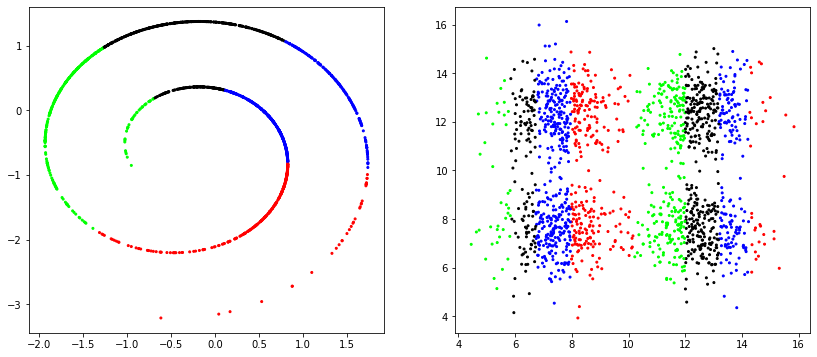

In [11]:
data_on_rne, indexes, H = robust_neighbor_embedding(data, n_neighbors=15, out_dim=2,mode=1)
kmc = KMeans(n_clusters=n_clusters, n_init=100, max_iter=300, tol=0.0001)
rne_clusters = kmc.fit_predict(data_on_rne)

colors = ['red','lime','blue','black']

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data_on_rne[:,0], data_on_rne[:,1],c = rne_clusters, 
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
#ax1.set_title('K-means on RNE domain')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(swissroll_2d[:,0], swissroll_2d[:,1],c = rne_clusters, 
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
#ax2.set_title('Clustering results on original 2D domain')

fig.set_size_inches(14,6)
plt.show()
